# Overview

In this project, the focus is the real estate sector in Argentina, I will be creating a machine learning model that predicts apartment prices in Buenos Aires, Argentina. In this project, we are working for a client who wants to create a model that can predict the price of apartments in the city of Buenos Aires — with a focus on apartments that cost less than $400,000 USD

Some of the key things I will be doing in this project are:

- Creating a linear regression model using the scikit-learn library.
- Building a data pipeline for imputing missing values and encoding categorical features.
- Improving model performance by reducing overfitting.
- Creating a dynamic dashboard for interacting with your completed model.

The first step is to import all the neccessary libraries needed for the project as shown below:

In [1]:
import warnings

import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LinearRegression #Build our model
from sklearn.metrics import mean_absolute_error #Evaluate our model
from sklearn.utils.validation import check_is_fitted

warnings.simplefilter(action="ignore", category=FutureWarning)

# Prepare Data

## Import

One way to automate the data importing and cleaning process is by writing a **function**. This will make sure that all our data undergoes the same process, and that our analysis is easily reproducible — something that's very important in science in general and data science in particular.

**Task 1.1:** We write a function named **wrangle** that takes a file path as an argument and returns a DataFrame.

In [2]:
def wrangle (filepath):
    #Read CSV file into dataframe
    df = pd.read_csv(filepath)
    
    #Subset to properties in 'Capital Federal'
    mask_ba = df["place_with_parent_names"].str.contains("Capital Federal")
    #Subset to properties that are 'apartments'
    mask_apt = df["property_type"] == "apartment"
    #Subset to price that are less than '$400,000'
    mask_price = df["price_aprox_usd"] < 400000
    
    #Subset
    df = df[mask_ba & mask_apt & mask_price]
    
    #Remove outliers by 'Surface Area Covered'
    low, high = df["surface_covered_in_m2"].quantile([0.1, 0.9])
    mask_area = df["surface_covered_in_m2"].between(low, high)
    df = df[mask_area]
    
    return df

**Task 1.2:** We will now use the wrangle function to create a DataFrame df from our CSV file.

In [3]:
df = wrangle (r"C:\Users\Ifeoluwa Faleye\OneDrive - Prunedge\Desktop\Data Analysis Projects\Python\Argentina Real Estate\buenos-aires-real-estate-1.csv")
print("df shape:", df.shape)
df.head()

df shape: (1343, 16)


,operation,property_type,place_with_parent_names,lat-lon,price,currency,price_aprox_local_currency,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2,price_per_m2,floor,rooms,expenses,properati_url
4,sell,apartment,|Argentina|Capital Federal|Chacarita|,"-34.5846508988,-58.4546932614",129000.0,USD,1955949.6,129000.0,76.0,70.0,1697.368421,1842.857143,NaN,NaN,NaN,http://chacarita.properati.com.ar/10qlv_venta_...
9,sell,apartment,|Argentina|Capital Federal|Villa Luro|,"-34.6389789,-58.500115",87000.0,USD,1319128.8,87000.0,48.0,42.0,1812.500000,2071.428571,NaN,NaN,NaN,http://villa-luro.properati.com.ar/12m82_venta...
29,sell,apartment,|Argentina|Capital Federal|Caballito|,"-34.615847,-58.459957",118000.0,USD,1789163.2,118000.0,NaN,54.0,NaN,2185.185185,NaN,2.0,NaN,http://caballito.properati.com.ar/11wqh_venta_...
40,sell,apartment,|Argentina|Capital Federal|Constitución|,"-34.6252219,-58.3823825",57000.0,USD,864256.8,57000.0,42.0,42.0,1357.142857,1357.142857,5.0,2.0,364.0,http://constitucion.properati.com.ar/k2f0_vent...
41,sell,apartment,|Argentina|Capital Federal|Once|,"-34.6106102,-58.4125107",90000.0,USD,1364616.0,90000.0,57.0,50.0,1578.947368,1800.000000,NaN,3.0,450.0,http://once.properati.com.ar/suwa_venta_depart...


In [4]:
# Check our work
assert (
    len(df) <= 1343
), f"`df` should have no more than 8606 observations, not {len(df)}."

For this project, we want to build a model for apartments in Buenos Aires proper (`"Capital Federal"`) that cost less than $400,000. Looking at the first five rows of our DataFrame, we can already see that there properties that fall outside those parameters. So our first cleaning task is to remove those observations from our dataset. Since we're using a function to import and clean our data, we'll need to make changes there.

In [14]:
mask_ba = df["place_with_parent_names"].str.contains("Capital Federal")
mask_ba

0        True
1       False
2       False
3       False
4        True
        ...  
8601     True
8602    False
8603    False
8604     True
8605    False
Name: place_with_parent_names, Length: 8606, dtype: bool

The code above is used to know for sure and check the first few indexes where `Capital Federal` is in the data. We can further filter the results to see a DataFrame that has `Capital Federal` in every entery as shown below:

In [15]:
df[mask_ba].head()

,operation,property_type,place_with_parent_names,lat-lon,price,currency,price_aprox_local_currency,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2,price_per_m2,floor,rooms,expenses,properati_url
0,sell,apartment,|Argentina|Capital Federal|Villa Crespo|,"-34.6047834183,-58.4586812499",180000.0,USD,2729232.0,180000.0,120.0,110.0,1500.000000,1636.363636,NaN,4.0,NaN,http://villa-crespo.properati.com.ar/12egq_ven...
4,sell,apartment,|Argentina|Capital Federal|Chacarita|,"-34.5846508988,-58.4546932614",129000.0,USD,1955949.6,129000.0,76.0,70.0,1697.368421,1842.857143,NaN,NaN,NaN,http://chacarita.properati.com.ar/10qlv_venta_...
9,sell,apartment,|Argentina|Capital Federal|Villa Luro|,"-34.6389789,-58.500115",87000.0,USD,1319128.8,87000.0,48.0,42.0,1812.500000,2071.428571,NaN,NaN,NaN,http://villa-luro.properati.com.ar/12m82_venta...
11,sell,apartment,|Argentina|Capital Federal|Once|,"-34.6050060697,-58.4001162302",60000.0,USD,909744.0,60000.0,28.0,28.0,2142.857143,2142.857143,NaN,1.0,NaN,http://once.properati.com.ar/zz0q_venta_depart...
18,sell,apartment,|Argentina|Capital Federal|Belgrano|,"-34.5646269,-58.4412741",600000.0,USD,9097440.0,600000.0,220.0,NaN,2727.272727,NaN,NaN,5.0,NaN,http://belgrano.properati.com.ar/jvge_venta_de...


From here, we update our wrangle function so that the DataFrame it returns only includes apartments in Buenos Aires (`"Capital Federal"`) that cost less than `$400,000 USD`. Then recreate df from data/buenos-aires-real-estate-1.csv by re-running the cells above.

# Explore

We will take a quick look at the distribution of apartment sizes in our dataset.

Task 1.3: We create a histogram of "surface_covered_in_m2".

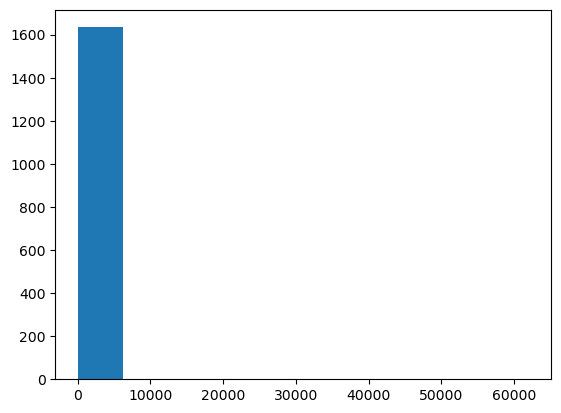

In [25]:
plt.hist(df["surface_covered_in_m2"])
plt.xlabel = ("Area [sq meters]")
plt.title = ("Distribution of Apartment Sizes")

A histogram like the one above suggests that there are outliers in our dataset. This can affect model performance — especially in the sorts of linear models. To confirm, we takt a quick look at the summary statistics for the `"surface_covered_in_m2"` feature.

In [26]:
df.describe()["surface_covered_in_m2"]

count     1635.000000
mean        97.877064
std       1533.057610
min          0.000000
25%         38.000000
50%         50.000000
75%         73.000000
max      62034.000000
Name: surface_covered_in_m2, dtype: float64

The statistics above confirm what we suspected. While most of the apartments in our dataset are smaller that 73 square meters, there are some that are several thousand square meters. The best thing to do is to change our wrangle function and remove them from the dataset.

In [28]:
low, high = df["surface_covered_in_m2"].quantile([0.1, 0.9])
mask_area = df["surface_covered_in_m2"].between(low, high)
mask_area

0       False
4        True
9        True
11      False
20      False
        ...  
8589     True
8590     True
8593     True
8601     True
8604     True
Name: surface_covered_in_m2, Length: 1781, dtype: bool

Task 1.4: We will add the above line of code to our wrangle function so that it removes observations that are outliers in the "surface_covered_in_m2" column. Specifically, all observations should fall between the 0.1 and 0.9 quantiles for "surface_covered_in_m2".

Now that our dataset is free of outliers, it's time to start exploring the relationship between apartment size and price. Let's use one of the tools we learned in the last project.

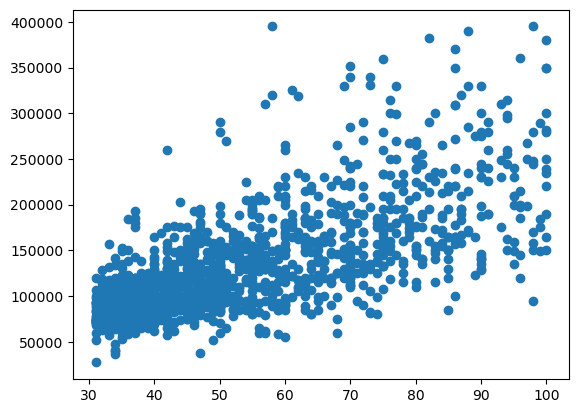

In [37]:
plt.scatter (x = df["surface_covered_in_m2"], y = df["price_aprox_usd"])
plt.xlabel = ("Area [sq meters]")
plt.ylabel = ("Price [USD]")
plt.title = ("Buenos Aires: Price vs Surface Area");

This plot suggests that there's a moderate positive correlation between apartment price and size. This means that if thing we want to predict is price, size will be a good feature to include.

# Split

A key part in any model-building project is separating our *target* (the thing you want to predict) from our features (the information our model will use to make its predictions). Since this is our first model, we'll use just one feature: `apartment size.`

**Task 1.5:** We create the feature matrix named X_train, which we'll use to train our model. It should contain one feature only: `["surface_covered_in_m2"]`. 

In [5]:
features = ["surface_covered_in_m2"]
X_train = df[features]
X_train.head()

,surface_covered_in_m2
4,70.0
9,42.0
29,54.0
40,42.0
41,50.0


In [6]:
# Check our work
assert X_train.shape == (
    1343,
    1,
), f"The shape of `X_train` should be (1343, 1), not {X_train.shape}."

Now that we have a features, the next step is to create a target. (By the way, you may have noticed that we're adding a `_train` tag to the variable names for our feature matrix and target vector. This is to remind us that this is the data we'll use to *train* our model, and not the data we'll use to test it.)

**Task 1.6:** We create the target vector named y_train, which you'll use to train your model. Our target should be `"price_aprox_usd"`. Remember that, in most cases, Our target vector should be one-dimensional.

In [7]:
target = "price_aprox_usd"
y_train = df["price_aprox_usd"]
y_train.head()

4     129000.0
9      87000.0
29    118000.0
40     57000.0
41     90000.0
Name: price_aprox_usd, dtype: float64

In [8]:
# Check our work
assert y_train.shape == (1343,)

# Build Model

## Baseine

The first step in building a model is baselining. To do this, we ask ourselves how we will know if the model we build is performing well?" One way to think about this is to see how a "dumb" model would perform on the same data. Some people also call this a naïve or baseline model, but it's always a model makes only one prediction — in this case, it predicts the same price regardless of an apartment's size. So let's start by figuring out what our baseline model's prediction should be.

**Task 1.7:** We calculate the mean of our target vector y_train and assign it to the variable y_mean.

In [9]:
y_mean = y_train.mean()
y_mean

135527.83871928515

Now that we have the one prediction that our dumb model will always make, we need to generate a list that repeats the prediction for every observation in our dataset.

In [10]:
y_pred_baseline = [y_mean] * len(y_train)
len(y_pred_baseline) == len(y_train)

True

So how does our baseline model perform? One way to evaluate it is by plotting it on top of the scatter plot we made above.

**Task 1.8:** We add a line to the plot below that shows the relationship between the observations `X_train` and our dumb model's predictions `y_pred_baseline`. Using the line color is orange, and that it has the label `"Baseline Model"`.

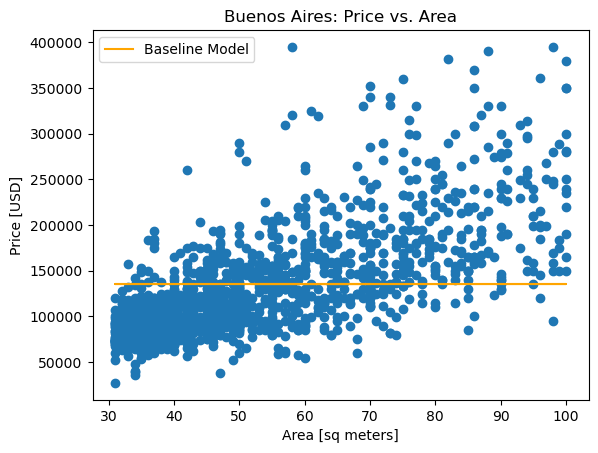

In [11]:
plt.plot(X_train.values, y_pred_baseline, color = "orange", label = "Baseline Model")
plt.scatter(X_train, y_train)
plt.xlabel("Area [sq meters]")
plt.ylabel("Price [USD]")
plt.title("Buenos Aires: Price vs. Area")
plt.legend();

Looking at this visualization, it seems like our baseline model doesn't really follow the trend in the data. But, as data scientists, we can't depend only on a subjective plot to evaluate a model. We need an exact, mathematically calculated performance metric. There are lots of **performance** metrics, but the one we'll use here is the **mean absolute error**.

**Task 1.9:** We calculate the baseline mean absolute error for our predictions in `y_pred_baseline` as compared to the true targets in `y`.

In [12]:
mae_baseline = mean_absolute_error (y_train, y_pred_baseline)

print("Mean apt price", round(y_mean, 2))
print("Baseline MAE:", round(mae_baseline, 2))

Mean apt price 135527.84
Baseline MAE: 45199.46


The information above means that if we always predicted that an apartment price is `$135,527.84`, our predictions would be off by an average of `$45,199.46`. It also tells us that our model needs to have mean absolute error below `$45,199.46` in order to be useful.

## Iterate

The next step in building our model is iterating. This involves building a model, training it, evaluating it, and then repeating the process until we're happy with the model's performance. Even though the model we're building is linear, the iteration process rarely follows a straight line.

The first thing we need to do is create our model — in this case, one that uses linear regression.

**Task 2.0:** Instantiate a `LinearRegression` model named model.

In [13]:
model = LinearRegression()

In [14]:
# Check our work
assert isinstance(model, LinearRegression)

The second thing we need to do is use our data to train our model. Another way to say this is fit our model to the training data.

**Task 2.1:** We fit our model to the data, `X_train` and `y_train`.

In [15]:
model.fit(X_train, y_train)

LinearRegression()

In [16]:
# Check our work
check_is_fitted(model)

## Evaluate

The final step is to evaluate our model. In order to do that, we'll start by seeing how well it performs when making predictions for data that it saw during training. So let's have it predict the price for the houses in our training set.

**Task 2.2:** Using our model's `predict` method, create a list of predictions for the observations in your feature matrix `X_train`. Name this array `y_pred_training`.

In [17]:
y_pred_training = model.predict(X_train)
y_pred_training[:5]

array([169151.87330223, 106064.44707446, 133101.91545779, 106064.44707446,
       124089.42599668])

In [18]:
# Check our work
assert (
    len(y_pred_training) == 1343
), f"There should be 1343 predictions in `y_pred_training`, not {len(y_pred_training)}."

Now that we have predictions, we'll use them to assess our model's performance with the training data. We'll use the same metric we used to evaluate our baseline model: mean absolute error.

**Task 2.3:** We calculate our training mean absolute error for your predictions in y_pred_training as compared to the true targets in y_train.

In [19]:
mae_training = mean_absolute_error(y_train, y_pred_training)
print("Training MAE:", round(mae_training, 2))

Training MAE: 31248.26


Our model beat the baseline by over $10,000! That's a good indicator that it will be helpful in predicting apartment prices. But the real test is how the model performs on data that it hasn't seen before, data that we call the test set. 

**Task 2.4:** We run the code below to import your test data into a DataFrame and generate a Series of predictions using your model.

In [31]:
X_test = pd.read_csv(r"C:\Users\Ifeoluwa Faleye\OneDrive - Prunedge\Desktop\Data Analysis Projects\Python\Argentina Real Estate\buenos-aires-test-features.csv")[features]
y_pred_test = pd.Series(model.predict(X_test))
y_pred_test.head()

0    117330.058901
1    135355.037823
2     88039.468152
3     88039.468152
4    106064.447074
dtype: float64

In [41]:
mae_testing = mean_absolute_error(X_test, y_pred_test)
print("Training MAE:", round(mae_testing, 2))

Training MAE: 134740.8
